# Implementing DeepDream

# Import

In [15]:
import imageio
from IPython.display import SVG
import numpy as np
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython.display as display
import cv2
import PIL.Image
from keras.utils.vis_utils import model_to_dot

Une autre utilisation des CNN entraînés consiste à exploiter le fait que certains nœuds intermédiaires détectent les caractéristiques des étiquettes (par exemple, l'oreille d'un chat ou la plume d'un oiseau). En utilisant ce fait, nous pouvons trouver des moyens de transformer n'importe quelle image pour refléter ces caractéristiques de nœud pour n'importe quel nœud que nous choisissons.

À l'origine, cette technique a été inventée pour mieux comprendre comment un CNN voit. L'objectif de DeepDream est de surinterpréter les motifs que le modèle détecte et de générer un contenu visuel inspirant avec des motifs surréalistes. Cet algorithme est un nouveau type d'art psychédélique.

# Sommaire

[I. Loading images](#Partie1) 

[II. Setting up model](#Partie2) 

## I. Loading images <a class="anchor" id="Partie1"></a>

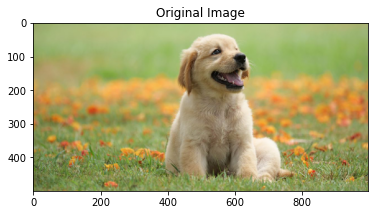

In [16]:
# Read the images 
original_img_file = 'image/dog.jpg' 
original_img = imageio.imread(original_img_file)

# Reshape to 500 max dimension
new_shape = tf.cast((500, 500 * original_img.shape[1] / original_img.shape[0]), tf.int32)
original_img = tf.image.resize(original_img, new_shape, method='nearest').numpy()

# Display the image
plt.figure()
plt.imshow(original_img)
plt.title("Original Image")
plt.show()

## II. Setting up model <a class="anchor" id="Partie2"></a>

In [17]:
'''
Load the Inception model pre-trained on ImageNet without the classification head. 
'''

inception_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet') 
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_188 (Conv2D)            (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_188 (Batch  (None, None, None,   96         ['conv2d_188[0][0]']             
 Normalization)                 32)                                                    

In [18]:
'''
We will select the convolutional layers to use for DeepDream processing later.
In a CNN, the earlier layers extract basic features such as edges, shapes, textures, 
and so on, while the deeper layers extract high-level features such as clouds, trees, or birds. 
To create a DeepDream image, we will focus on the layers where the convolutions are mixed. 
Now, we'll create the feature extraction model with the two mixed layers as outputs
'''

names = ['mixed3', 'mixed5']
layers = [inception_model.get_layer(name).output for name in names]
deep_dream_model = tf.keras.Model(inputs=inception_model.input, outputs=layers) # Les outputs de notre modèle sont ici les couches mixed3 et mixed5

In [19]:
'''
We will define the loss function that returns the sum of all output layers
'''

def compute_loss(img, model):
  # Add a dimension to the image to have a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  # Apply the model to the images and get the outputs to retrieve the activation.
  layer_activations = model(img_batch)
  
  # Compute the loss for each layer
  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)
    
  return  tf.reduce_sum(losses)

In [20]:
'''
We declare two utility functions that undo the scaling and display a processed image
'''

def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

In [21]:
def run_deep_dream(image, steps=100, step_size=0.01):
    # Apply the Inception preprocessing
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    image = tf.convert_to_tensor(image)
    loss = tf.constant(0.0)

    for n in tf.range(steps):
        # We use gradient tape to track TensorFlow computations
        with tf.GradientTape() as tape:
            # We use watch to force TensorFlow to track the image
            tape.watch(image)
            # We compute the loss
            loss = compute_loss(image, deep_dream_model)
        # Compute the gradients
        gradients = tape.gradient(loss, image)
        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # Perform the gradient ascent by directly adding the gradients to the image
        image = image + gradients*step_size
        image = tf.clip_by_value(image, -1, 1)
        
        # Display the intermediate image
        if (n % 100 ==0):
            display.clear_output(wait=True)
            show(deprocess(image))
            print ("Step {}, loss {}".format(n, loss))
    
    # Display the final image
    result = deprocess(image)
    display.clear_output(wait=True)
    show(result)
    return result

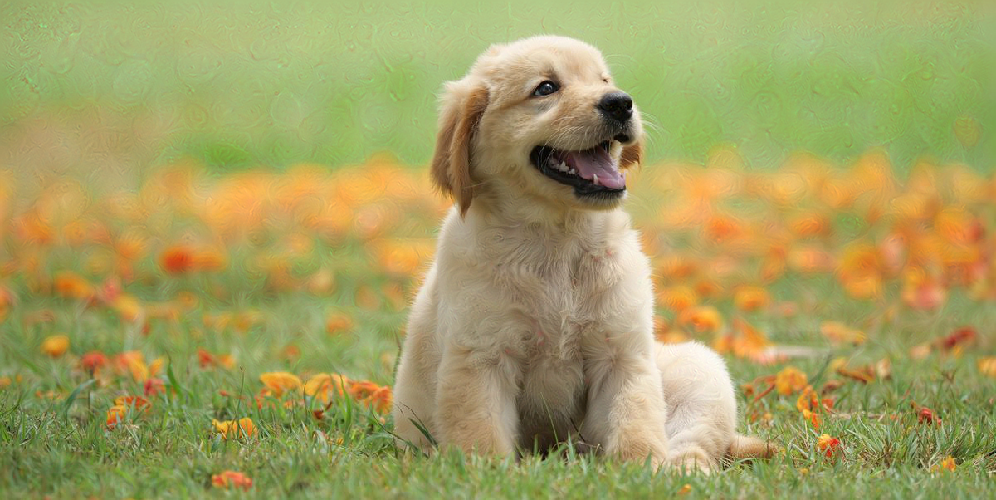

In [22]:
'''
We will run DeepDream on the original image
'''

dream_img = run_deep_dream(image=original_img,steps=3, step_size=0.01)

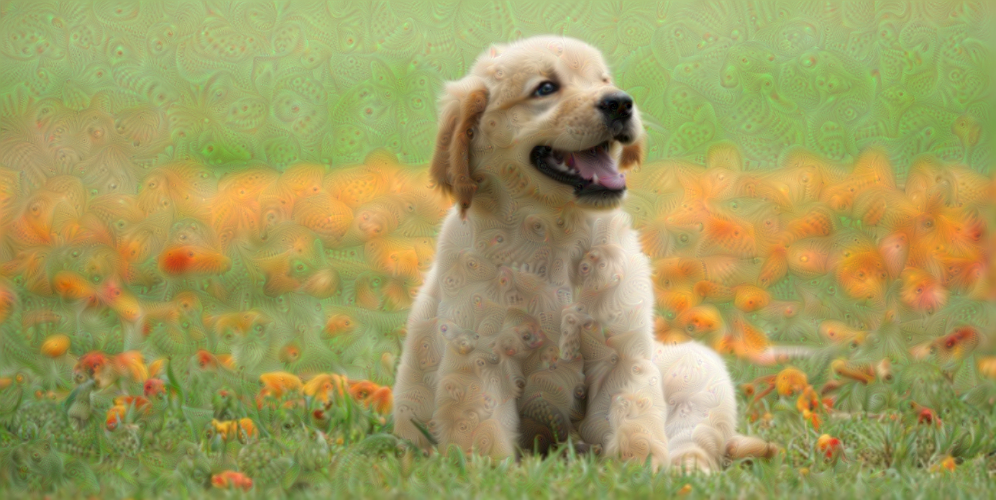

In [23]:
'''
To make images better, we can use the concept of octaves. 
We perform gradient ascent on the same image resized multiple times 
(each step of increasing the size of an image is an octave improvement). 
Using this process, the detected features at a smaller scale could be 
applied to patterns at higher scales with more details.
'''


OCTAVE_SCALE = 1.30
image = tf.constant(np.array(original_img))
base_shape = tf.shape(image)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    # Increase the size of the image
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
    image = tf.image.resize(image, new_shape).numpy()
    # Apply deep dream
    image = run_deep_dream(image=image, steps=3, step_size=0.01)

# Display output
display.clear_output(wait=True)
image = tf.image.resize(image, base_shape)
image = tf.image.convert_image_dtype(image/255.0, dtype=tf.uint8)
show(image)